In this cell,

1.I'm extracting the MNIST dataset from torchvision library and then performing augmentation like RandomRotation,RandomCrop,ToTensor and Normalize on train set of data.

2.Performing split of the dataset into train,test and validation.

3.Printing some images from each class and creating date loaders for train and test set.

4.Creating/Implementing 3-layer MLP Model using PyTorch.

device used:- cuda
------------------------------------------------------------------------------------------------
Training Dataset


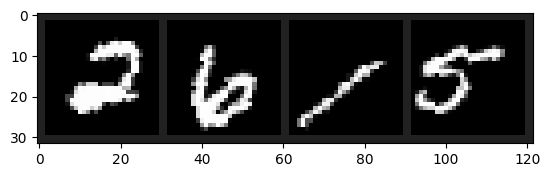

    2     6     1     5
----------------------------------------------------------------------------------------------------
Testing Dataset


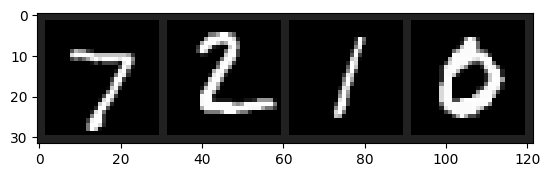

    7     2     1     0
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Class 0:


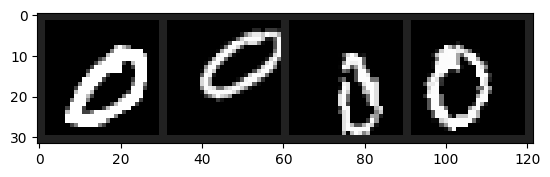

----------------------------------------------------------------------------------------------------
Class 1:


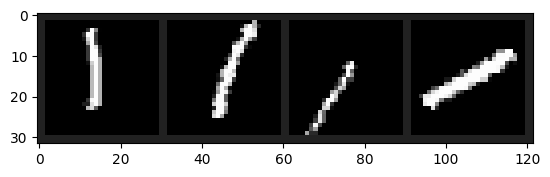

----------------------------------------------------------------------------------------------------
Class 2:


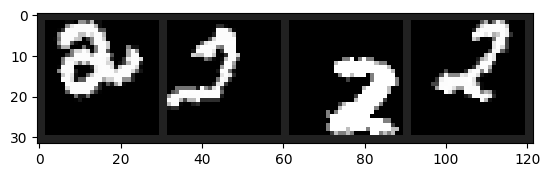

----------------------------------------------------------------------------------------------------
Class 3:


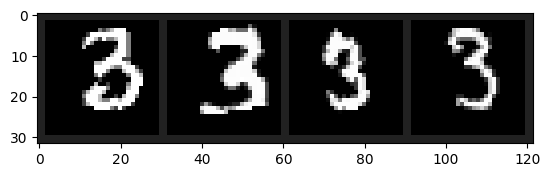

----------------------------------------------------------------------------------------------------
Class 4:


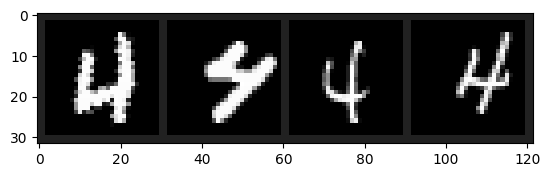

----------------------------------------------------------------------------------------------------
Class 5:


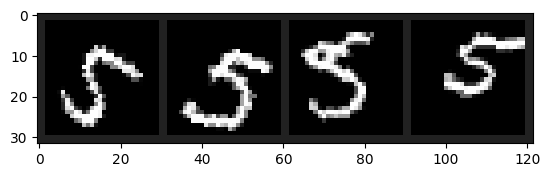

----------------------------------------------------------------------------------------------------
Class 6:


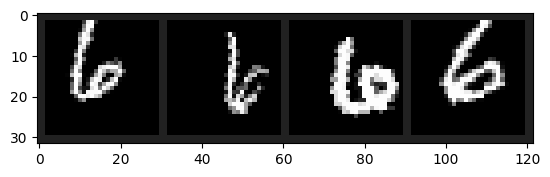

----------------------------------------------------------------------------------------------------
Class 7:


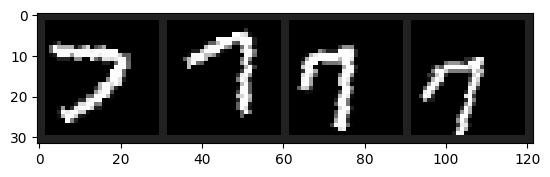

----------------------------------------------------------------------------------------------------
Class 8:


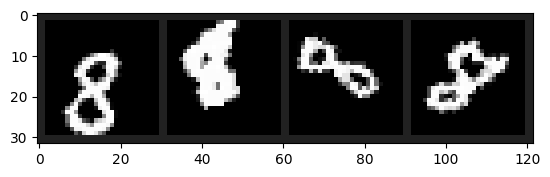

----------------------------------------------------------------------------------------------------
Class 9:


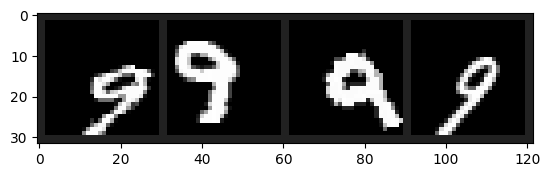

----------------------------------------------------------------------------------------------------
Number of trainable parameters: 109386


In [14]:
#IMPORTING REQUIRED LIBRARIES
import torch
import os
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
#for progress bar
from tqdm.notebook import tqdm
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device used:-", device)
print("------------------------------------------------------------------------------------------------")

#Task0
import torchvision
import torchvision.transforms as transforms
# Defining transformations for data augmentation(train set)
train_transform = transforms.Compose([
    transforms.RandomRotation(29),  # Randomly rotate images by up to 29 degrees
    transforms.RandomCrop(28, padding=4),  # Randomly crop images with padding of 4 pixels
    transforms.ToTensor(),  #images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizing the images
])
# Defining transformation for validation and test sets (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
#MNIST dataset
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)
# Performing data split for validation
val_ratio = 0.1
num_train = len(train_set)
indices = list(range(num_train))
split = int(val_ratio * num_train)
torch.manual_seed(29)
torch.randperm(num_train)
train_idx, val_idx = indices[split:], indices[:split]
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

#Task1
# Defining data loaders for train, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, sampler=train_sampler,shuffle=False)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=64, sampler=val_sampler,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
#showing images
def imshow(img):
    img = img * 0.3081 + 0.1307  # Reverse normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
#train dataset
print("Training Dataset")
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Showing images
imshow(torchvision.utils.make_grid(images[:4]))
# Printing labels
print(' '.join('%5s' % labels[j].item() for j in range(4)))
print("----------------------------------------------------------------------------------------------------")
#test dataset
#random testing images
print("Testing Dataset")
dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join('%5s' % labels[j].item() for j in range(4)))
print("------------------------------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------------------------------")
# Function to print some images of each class
def print_class_images(loader):
    class_images = [[] for _ in range(10)]
    class_count = [0] * 10
    with torch.no_grad():
        for inputs, labels in loader:
            for i in range(len(labels)):
                label = labels[i].item()
                if class_count[label] < 4:
                    class_images[label].append(inputs[i])
                    class_count[label] += 1
            if all(count == 4 for count in class_count):
                break
    for class_label, images in enumerate(class_images):
        print(f"Class {class_label}:")
        imshow(torchvision.utils.make_grid(images))
        print("----------------------------------------------------------------------------------------------------")

print_class_images(train_loader)

#Task2
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_dims[0]))
        self.layers.append(nn.ReLU())
        # Hidden layers
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            self.layers.append(nn.ReLU())
        # Output layer
        self.layers.append(nn.Linear(hidden_dims[-1], output_dim))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        for layer in self.layers:
            x = layer(x)
        return x

input_dim = 28 * 28  # MNIST image size
hidden_dims = [128, 64]  # Hidden layer dimensions
output_dim = 10  # Number of classes in MNIST

# Instance of the MLP
model = MLP(input_dim, hidden_dims, output_dim)

# Number of trainable parameters in the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", total_params)



In this Cell,The model is trained using adam as optimizer and cross_entropy_loss as the loss function.
Also,the accuracy of the model on train and validation set is logged after
every epoch and stored in lists

In [15]:
#Task3
import torch.optim as optim
# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
# Specifying number of epochs (iterations)
num_epochs = 5
best_val_acc = 0.0
best_model = None

# Lists to store metrics for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(data_loader)
    train_accuracy = 100 * correct_train / total_train

    return train_loss, train_accuracy

def val_epoch(model, data_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(data_loader)
    val_accuracy = 100 * correct_val / total_val

    return val_loss, val_accuracy

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = val_epoch(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Saving the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()

# Saving the best model
torch.save(best_model, 'best_model.pth')

Epoch [1/5], Training Loss: 0.8460, Training Accuracy: 72.40%, Validation Loss: 0.4777, Validation Accuracy: 85.57%
Epoch [2/5], Training Loss: 0.4323, Training Accuracy: 86.56%, Validation Loss: 0.3793, Validation Accuracy: 89.02%
Epoch [3/5], Training Loss: 0.3575, Training Accuracy: 88.98%, Validation Loss: 0.3026, Validation Accuracy: 90.92%
Epoch [4/5], Training Loss: 0.3222, Training Accuracy: 89.98%, Validation Loss: 0.2827, Validation Accuracy: 91.30%
Epoch [5/5], Training Loss: 0.2931, Training Accuracy: 90.79%, Validation Loss: 0.2750, Validation Accuracy: 91.97%


Visualization of Correct and Incorrect Predictions using Loss-Epoch and Accuracy Epoch Graphs

Correct Predictions:
Actual: 7 Predicted: 7 

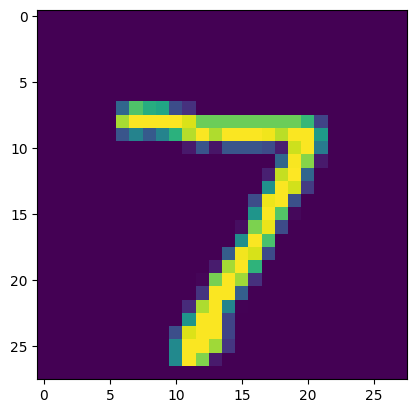


Actual: 2 Predicted: 2 

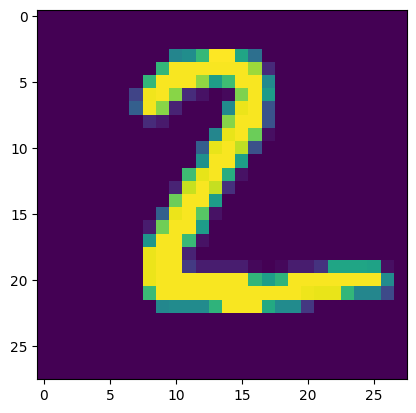


Actual: 1 Predicted: 1 

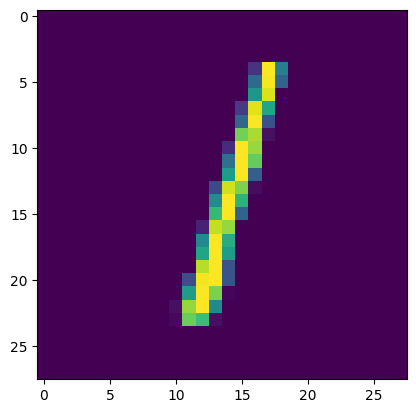


Actual: 0 Predicted: 0 

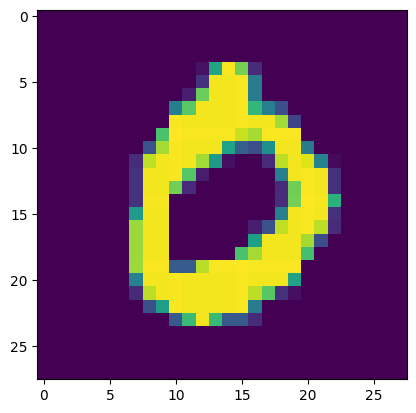


Incorrect Predictions:
Actual: 5 Predicted: 6 

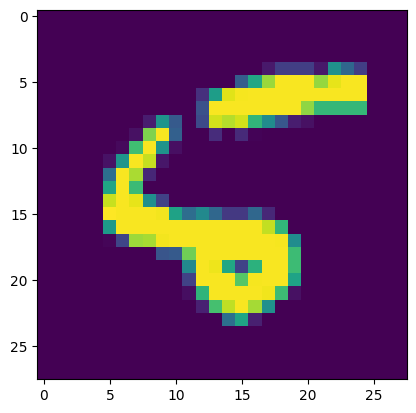


Actual: 9 Predicted: 5 

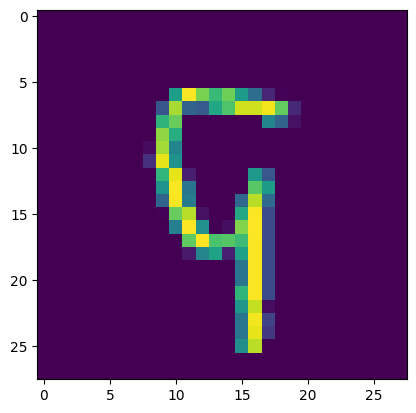


Actual: 7 Predicted: 9 

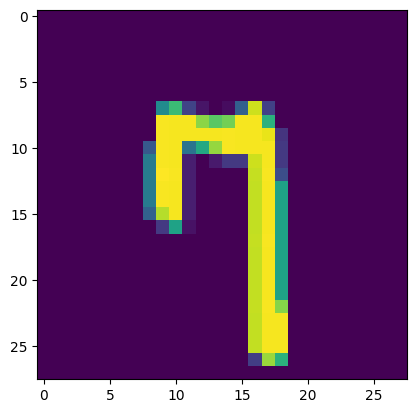


Actual: 2 Predicted: 9 

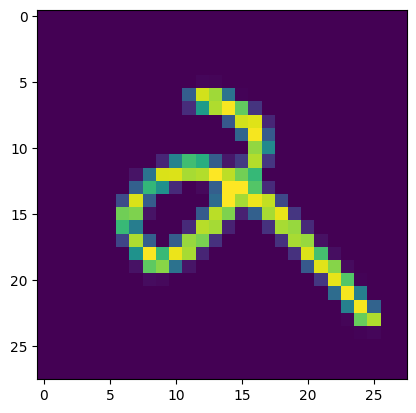

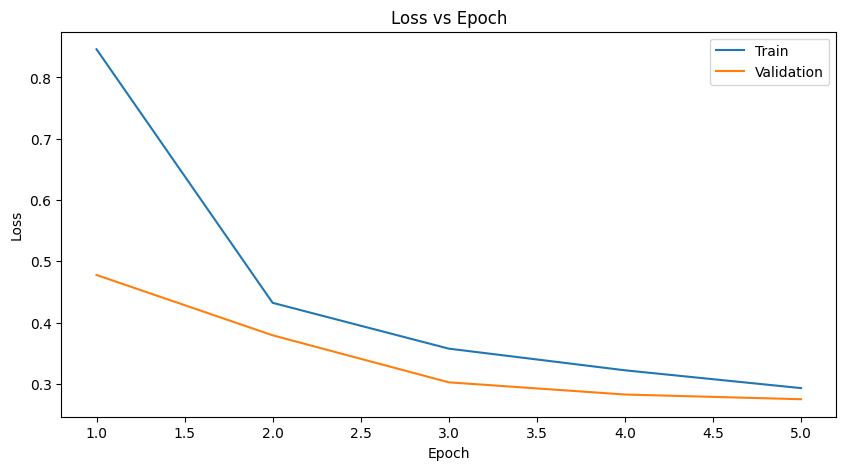

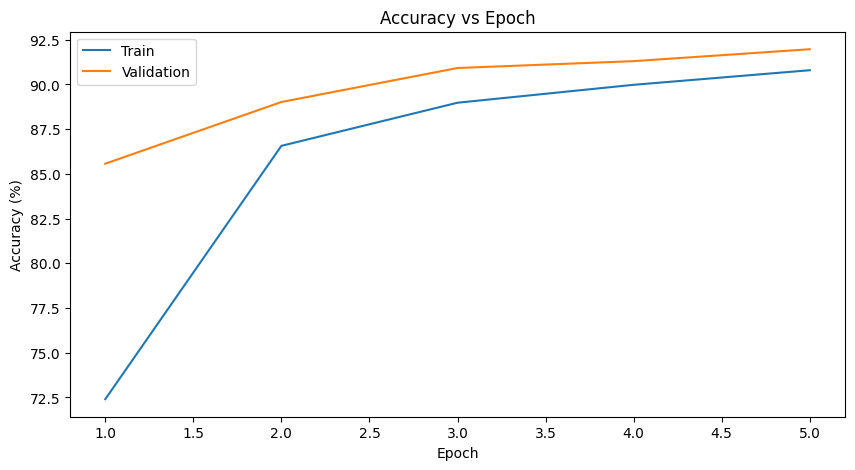

Training Dataset


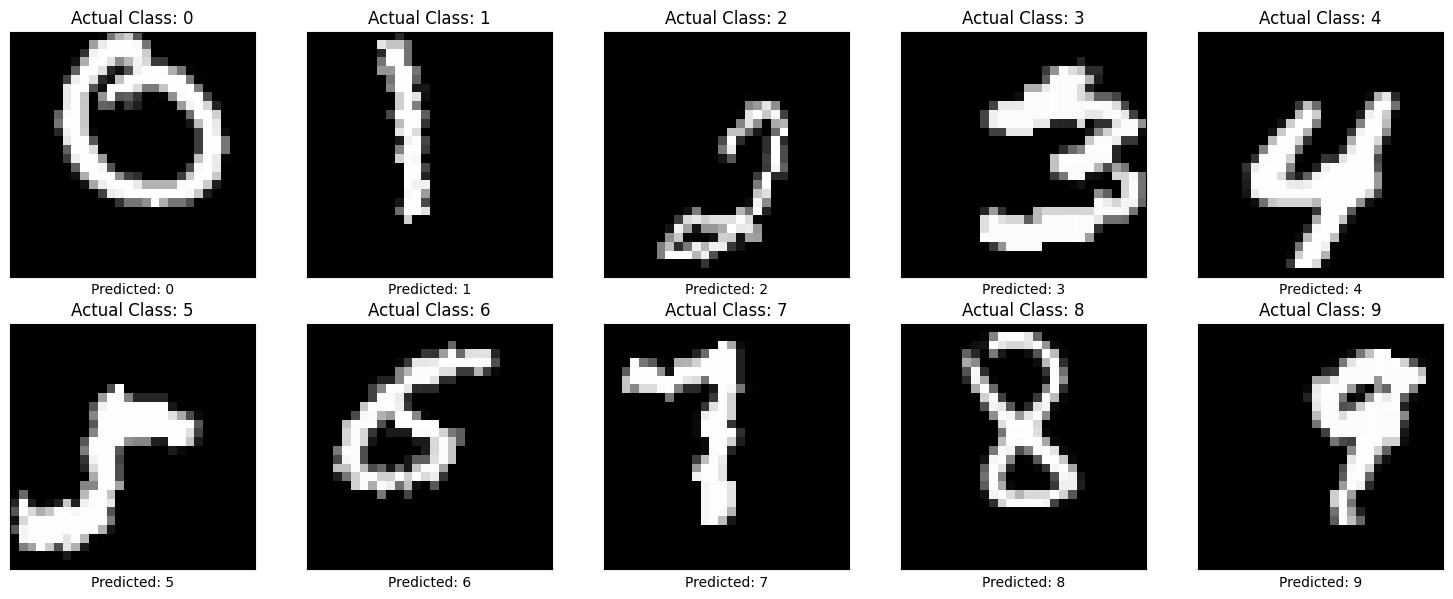

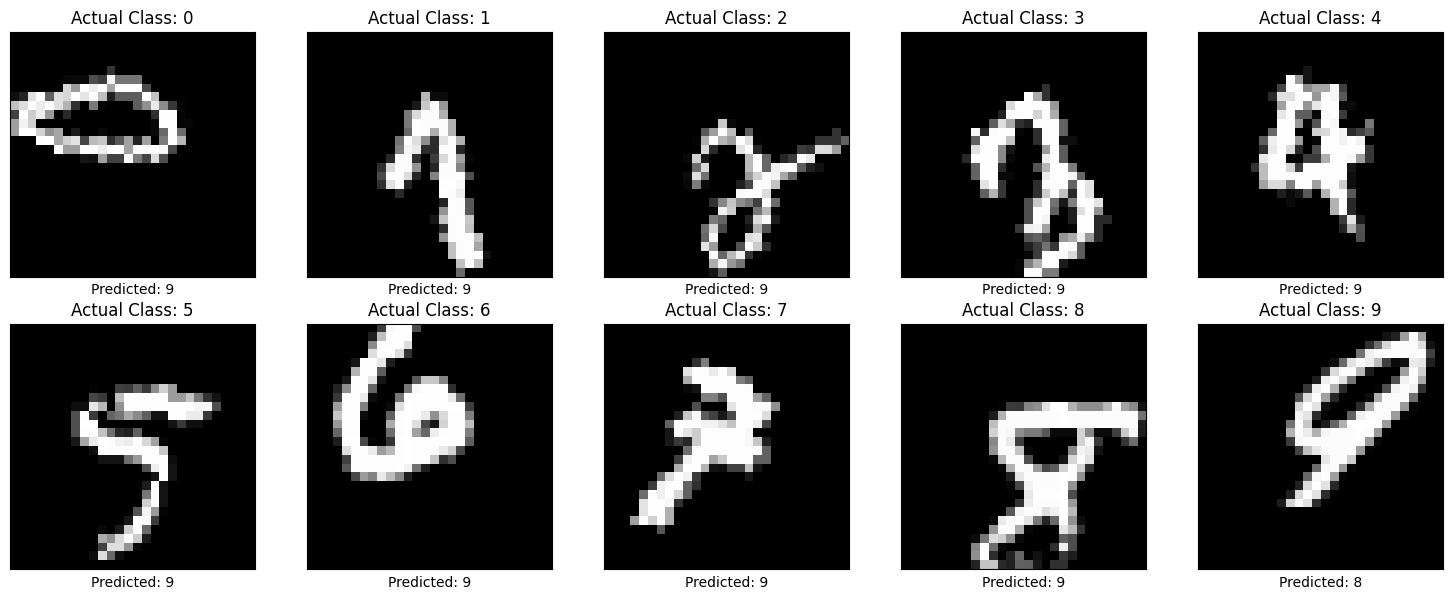

Testing Dataset


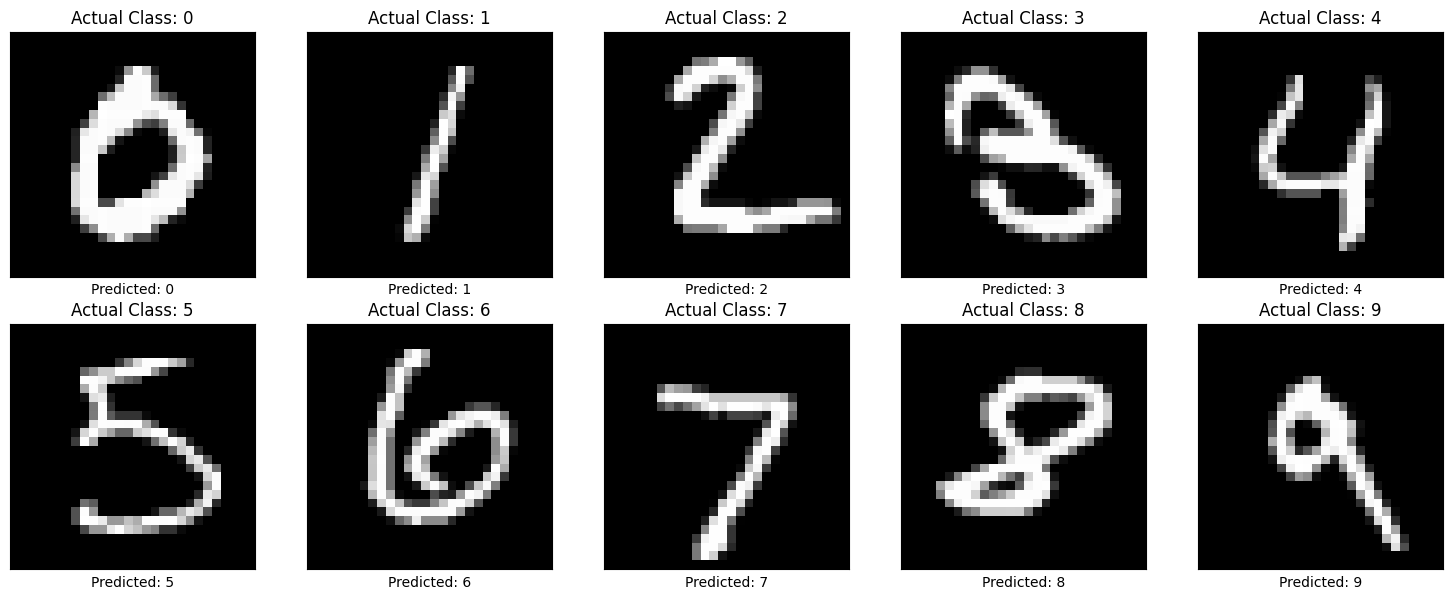

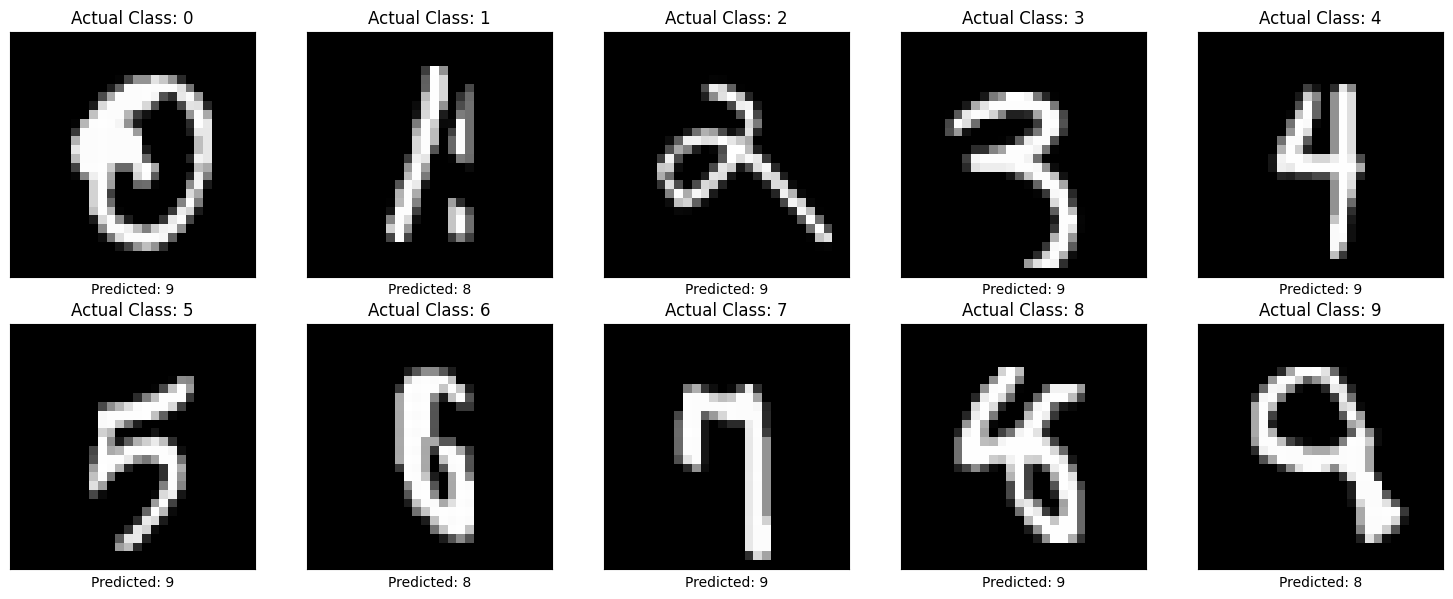

In [18]:
#Task4
#visualizing correct and incorrect predictions

def visualize_predictions(loader, model):
    model.eval()
    correct_images = []
    incorrect_images = []
    correct_labels = []
    incorrect_labels = []
    correct_predictions = []
    incorrect_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(predicted)):
                if predicted[i] == labels[i]:
                    correct_images.append(inputs[i])
                    correct_labels.append(labels[i].item())
                    correct_predictions.append(predicted[i].item())
                else:
                    incorrect_images.append(inputs[i])
                    incorrect_labels.append(labels[i].item())
                    incorrect_predictions.append(predicted[i].item())

    print("Correct Predictions:")
    for i, image in enumerate(correct_images[:4]):
        print(f"Actual: {correct_labels[i]} Predicted: {correct_predictions[i]}", end=" ")
        imshow(image)
        print()

    print("Incorrect Predictions:")
    for i, image in enumerate(incorrect_images[:4]):
        print(f"Actual: {incorrect_labels[i]} Predicted: {incorrect_predictions[i]}", end=" ")
        imshow(image)
        print()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# plotting Loss-Epoch and Accuracy-Epoch graphs
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Loss-Epoch graph
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train')
    plt.plot(epochs, val_losses, label='Validation')
    plt.title('Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy-Epoch graph
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Train')
    plt.plot(epochs, val_accuracies, label='Validation')
    plt.title('Accuracy vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

#correct and incorrect predictions
visualize_predictions(test_loader, model)

#Loss-Epoch and Accuracy-Epoch graphs
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

def print_classwise_predictions(loader, model):
    model.eval()
    correct_images = [[[[] for _ in range(10)] for _ in range(10)] for _ in range(10)]
    incorrect_images = [[[[] for _ in range(10)] for _ in range(10)] for _ in range(10)]
    correct_labels = [[[[] for _ in range(10)] for _ in range(10)] for _ in range(10)]
    incorrect_labels = [[[[] for _ in range(10)] for _ in range(10)] for _ in range(10)]
    correct_predictions = [[[[] for _ in range(10)] for _ in range(10)] for _ in range(10)]
    incorrect_predictions = [[[[] for _ in range(10)] for _ in range(10)] for _ in range(10)]

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(len(predicted)):
                actual_label = labels[i].item()
                predicted_label = predicted[i].item()

                if predicted[i] == labels[i]:
                    correct_images[actual_label][predicted_label][0].append(inputs[i])
                    correct_labels[actual_label][predicted_label][0].append(actual_label)
                    correct_predictions[actual_label][predicted_label][0].append(predicted_label)
                else:
                    incorrect_images[actual_label][predicted_label][0].append(inputs[i])
                    incorrect_labels[actual_label][predicted_label][0].append(actual_label)
                    incorrect_predictions[actual_label][predicted_label][0].append(predicted_label)

    # Correct predictions class-wise
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    for actual_class in range(10):
        row = actual_class // 5
        col = actual_class % 5
        axes[row, col].set_title(f"Actual Class: {actual_class}")
        for predicted_class in range(10):
            if correct_images[actual_class][predicted_class][0]:
                image = correct_images[actual_class][predicted_class][0][0]
                label = correct_labels[actual_class][predicted_class][0][0]
                prediction = correct_predictions[actual_class][predicted_class][0][0]
                axes[row, col].imshow(image.permute(1, 2, 0), cmap='gray')
                axes[row, col].set_xlabel(f"Predicted: {prediction}")
                axes[row, col].set_xticks([])
                axes[row, col].set_yticks([])

    plt.tight_layout()
    plt.show()

    # Incorrect predictions class-wise
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    for actual_class in range(10):
        row = actual_class // 5
        col = actual_class % 5
        axes[row, col].set_title(f"Actual Class: {actual_class}")
        for predicted_class in range(10):
            if incorrect_images[actual_class][predicted_class][0]:
                image = incorrect_images[actual_class][predicted_class][0][0]
                label = incorrect_labels[actual_class][predicted_class][0][0]
                prediction = incorrect_predictions[actual_class][predicted_class][0][0]
                axes[row, col].imshow(image.permute(1, 2, 0), cmap='gray')
                axes[row, col].set_xlabel(f"Predicted: {prediction}")
                axes[row, col].set_xticks([])
                axes[row, col].set_yticks([])

    plt.tight_layout()
    plt.show()

# Printing correct and incorrect predictions class-wise for the training dataset
print("Training Dataset")
print_classwise_predictions(train_loader, model)

# Printing correct and incorrect predictions class-wise for the testing dataset
print("Testing Dataset")
print_classwise_predictions(test_loader, model)
